In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
train_data  = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test_data  = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [3]:
test_data.head(3)

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [4]:
labels_efs = train_data['efs']
labels_efs_time = train_data['efs_time']

train_data.drop( ['ID' , 'efs' ,'efs_time'] , axis=1 , inplace = True )

test_id = test_data['ID']

test_data.drop( 'ID' , axis=1 ,  inplace = True )

In [5]:
data_dict = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')


In [6]:
cat_cols = []
num_cols = [] 

for i in range( len(data_dict) )  :
    curr = data_dict.loc[i]['variable']
    
    if data_dict.loc[i]['type']=='Categorical' :
        cat_cols.append( curr )
    else :
        num_cols.append( curr )

print( len(cat_cols) )

if 'ID' in cat_cols :
    cat_cols.remove('id')
elif 'ID' in num_cols :
    num_cols.remove('id')
 
# no id till now 

36


In [7]:
# train_data['efs'].unique()

cat_cols.remove('efs')


In [8]:
# DO  ORDINAL ENCODING WITH CAT COLS WITH ( NO = 0 , YES = 1 , NOT DONE =-1 , NaN = mode high freq )

cols_4_cat = [] 

for col in cat_cols :
    if  set(['No' ,'Yes' ,'Not done']).issubset(train_data[col].unique()) :
        cols_4_cat.append( col )

print( len(cols_4_cat))

# impute with mode (f ro cosl with 3-4 categories of yes , no , not done )

for col in cols_4_cat :
    train_data.fillna( { col : train_data[col].mode()[0] } , inplace  =True )
    test_data.fillna( { col : train_data[col].mode()[0] } , inplace  =True )

# cols with ONLY no yes  , impute with mode 

cols_2_cat = []

for col in cat_cols :
    un_ = train_data[col].unique()
    if len(un_)==3 and ('No' in un_) and ( 'Yes' in un_ ) and not ('Not done' in un_):
        cols_2_cat.append(col)

        
for col in cols_2_cat :
    train_data.fillna( { col : train_data[col].mode()[0]} , inplace = True )
    # to prevent Data Leakege prevent mode of test Data 
    test_data.fillna( { col : train_data[col].mode()[0]} , inplace = True )
    

13


In [9]:
# Now , do Ordinal encoding 

from sklearn.preprocessing import OrdinalEncoder 

ordinal_en = OrdinalEncoder()

train_data[cols_2_cat] = ordinal_en.fit_transform( train_data[cols_2_cat])
train_data[cols_4_cat] = ordinal_en.fit_transform( train_data[cols_4_cat])


# no problem of Data Leakegae 

test_data[cols_2_cat] = ordinal_en.fit_transform( test_data[cols_2_cat])
test_data[cols_4_cat] = ordinal_en.fit_transform( test_data[cols_4_cat])


In [10]:
# Noe for remaining cat collumns , I am taking (according to domain knowledge) only thos categorcial data 
# can make an unbiased system 

rem_cat_cols_ordinal = ['dri_score' ,'cyto_score' ,'mrd_hct']
rem_cat_cols_ohe = ['graft_type' , 'donor_related' ,'ethnicity']


for col in rem_cat_cols_ordinal :
    train_data.fillna( { col : train_data[col].mode()[0] } , inplace  =True )
    test_data.fillna( { col : train_data[col].mode()[0] } , inplace  =True )


for col in rem_cat_cols_ohe :
    train_data.fillna( { col : train_data[col].mode()[0] } , inplace  =True )
    test_data.fillna( { col : train_data[col].mode()[0] } , inplace  =True )

# confusing cols = prime_disease_hct


In [11]:
df= train_data.select_dtypes(['object'])

obj_cols = list ( df.columns )

print(len(obj_cols))

# after ordinal encoding , the data type of cat cols(object type) change to int/float 

# Ordinal encoding

train_data[ rem_cat_cols_ordinal ] = ordinal_en.fit_transform( train_data[rem_cat_cols_ordinal])
test_data[ rem_cat_cols_ordinal ] = ordinal_en.fit_transform( test_data[rem_cat_cols_ordinal])

# OHE (one hot encoding)
ohe_df = (pd.get_dummies( train_data[rem_cat_cols_ohe]  ,dummy_na =True , dtype = float ))

train_data.drop(rem_cat_cols_ohe , axis=1  )

train_data = train_data.join ( ohe_df )


# OHE for Test Data 

''' I CASE TEST DATA HAS FEWER CATEGORIES THAN TRAIN , THEN cols (from OHE) 
in Test Data will be < Trisn data ohe cols 
'''

ohe_df_test = (pd.get_dummies( test_data[rem_cat_cols_ohe]  , dtype = float ))




test_data.drop(rem_cat_cols_ohe , axis=1  )

test_data = test_data.join ( ohe_df_test )

for col in train_data.columns :
    if col not in test_data.columns :
        test_data[col] = [0]*len(test_data)


19


In [12]:
# now remove rest obj cols 

train_data = train_data.select_dtypes(  exclude = ['object'])
test_data = test_data.select_dtypes(  exclude = ['object'])




In [13]:
# Pre-Prcoess Numericla Data 

num_cols.remove('efs_time')

for col  in num_cols :
    # patients follwo skewed distribution so going with same flow 
    train_data.fillna( {col : train_data[col].mean() } , inplace = True )
    test_data.fillna( {col : train_data[col].mean() } , inplace = True )

In [14]:
print( " Features in Training Dataset {}".format( len(train_data.columns)))

print( " Features in Test Dataset {}".format( len(test_data.columns)))

 Features in Training Dataset 52
 Features in Test Dataset 52


In [15]:
for col in train_data.columns :
    if col not in test_data.columns :
        print(col)

In [16]:
features = train_data 
labels = labels_efs

# trian-test split ratio
n = 1.0

X_train = features[: int(n*len(features )) ]
y_train = labels[ : int (n*len(features )) ]

# X_valid = features[ int(n*len(features )) :]
# y_valid = labels[ int (n*len(features )) :]




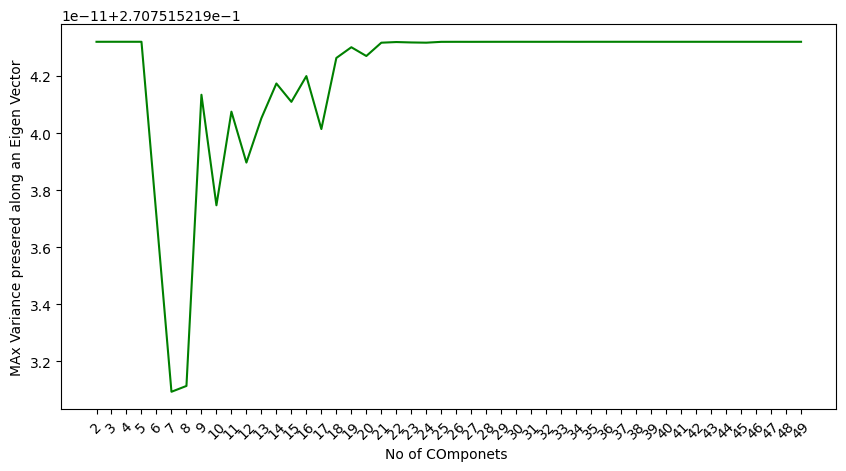

In [17]:
# Applying PCA on Data  ( highly correlated Data ) s.t we take eigen vectors 
# where maximum eigen vlaue is stored ( max variance is preserved . )

from sklearn.decomposition import PCA 

m = X_train.shape[0] # no of training examples 
n = X_train.shape[1] # no of features 

pca_ = 0 

X_dummy = X_train.copy()

# always standarize the Data before PCA 
#since PCA depends on variance of original feature s( so larger varainces can dominate te PCA results ) 

from sklearn.preprocessing import StandardScaler 

scale_norm  = StandardScaler()
X_dummy = scale_norm.fit_transform( X_dummy )


var = []

start_comp = 2 
end_comp =  50

for i in range( start_comp , end_comp  ) :
    pca_ = PCA( n_components = i )
    pca_.fit( X_dummy)
    var.append( max(pca_.explained_variance_ratio_ ) )
    

plt.figure( figsize = ( 10 , 5 ))
plt.plot( range( start_comp , end_comp  ) , var  ,'g')
plt.xlabel( 'No of COmponets ')
plt.xticks( range( start_comp , end_comp ) ,rotation = 45 )
plt.ylabel( 'MAx Variance presered along an Eigen Vector')
plt.show()




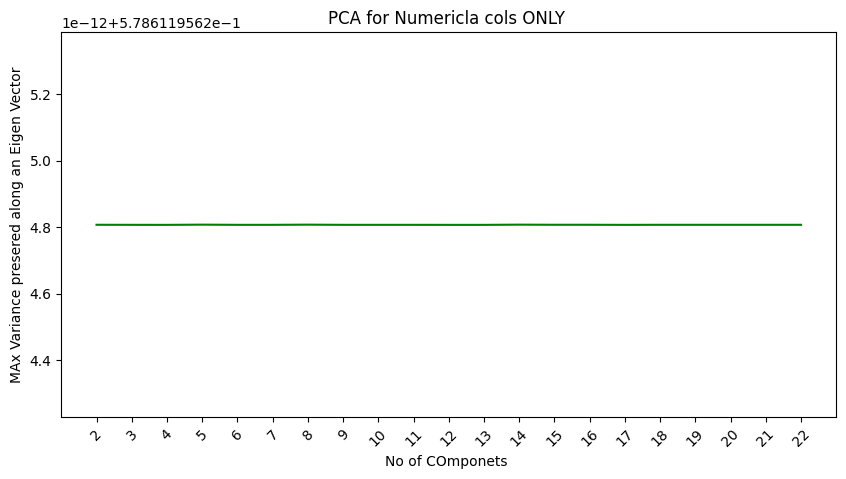

In [18]:
# PCA only wrt numericla cols 
# since it contains too much Correlated features 


pca_ = 0 

X_num = X_train.copy()[num_cols]


scale_norm_num = StandardScaler()
X_num = scale_norm_num.fit_transform( X_num )


var = []

start_comp = 2 
end_comp =  23

for i in range( start_comp , end_comp  ) :
    pca_ = PCA( n_components = i )
    pca_.fit( X_num )
    var.append( max(pca_.explained_variance_ratio_ ) )
    

plt.figure( figsize = ( 10 , 5 ))
plt.plot( range( start_comp , end_comp  ) , var  ,'g')
plt.title( 'PCA for Numericla cols ONLY ')
plt.xlabel( 'No of COmponets ')
plt.xticks( range( start_comp , end_comp ) ,rotation = 45 )
plt.ylabel( 'MAx Variance presered along an Eigen Vector')
plt.show()




In [19]:
# from the above Graph , the best components to reduce Datset into = 20 ( for PCA over whole Dataset )
# and SAME for ONLY numerival cols 

# Hence , we take N = 20 compinets 

PCA_  = PCA( n_components  = 20 )

#standarize 
scale_data  = StandardScaler()
X_train_scale = scale_data.fit_transform( X_train )


#PCA 
X_train_pca = PCA_.fit_transform( X_train_scale )
y_train_pca = y_train 



In [20]:
# # Building ML algos 

# from sklearn.ensemble import RandomForestClassifier 

# model = RandomForestClassifier ( n_estimators =   10 , criterion  = "entropy" , max_depth = 49,
#                                bootstrap = True ,warm_start = False )



In [21]:
# # random forets training   on Original Data 

# model.fit(X_train , y_train )

In [22]:
# # Cross Validation on original Data 
# from sklearn.model_selection import cross_val_score 


# scores = cross_val_score( model  , X_train , y_train  , cv = 3 )

# print( "The cross validation score have Mean = {} a with a std. dev of = {}".format(scores.mean() ,scores.std()) )


In [23]:
# # trianing and validation on Test Data 

# model_rand = RandomForestClassifier ( n_estimators =   10 , criterion  = "entropy" , max_depth = 49,
#                                bootstrap = True ,warm_start = False )


# model_rand.fit( X_train_pca , y_train_pca )



# scores = cross_val_score( model_rand , X_train_pca , y_train_pca  , cv = 3 )

# print( "The cross validation score have Mean = {} a with a std. dev of = {}".format(scores.mean() ,scores.std()) )

In [24]:
# Scaling the Data for nn 

X_train_nn = X_train.copy()
y_train_nn = y_train.copy()

from sklearn.preprocessing import MinMaxScaler 

scaler_ = MinMaxScaler( feature_range = (0 , 1 ))

X_train_nn = scaler_.fit_transform(X_train_nn)

In [25]:
# # Neural Network 

# from tensorflow import keras 

# from keras.layers import Dense , Input , BatchNormalization , Dropout

# model_nn = keras.models.Sequential()

# model_nn.add( Input( shape = (X_train_pca.shape[1] ,) , batch_size = 1024 ))

# model_nn.add( Dense( 120  , activation = 'tanh' ) ) 
# model_nn.add( BatchNormalization())


# # model_nn.add( Dense( 1024  , activation = 'relu' ) ) 
# # model_nn.add( BatchNormalization())

# # model_nn.add( Dense( 1024  , activation = 'relu' ) ) 
# # model_nn.add( BatchNormalization())

# # model_nn.add( Dense( 1024  , activation = 'relu' ) ) 
# # model_nn.add( BatchNormalization())

# model_nn.add( Dense( 1  , activation = 'sigmoid'))


# model_nn.compile( loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

# model_nn.fit( X_train_pca , y_train_pca , epochs = 3 )

<Axes: >

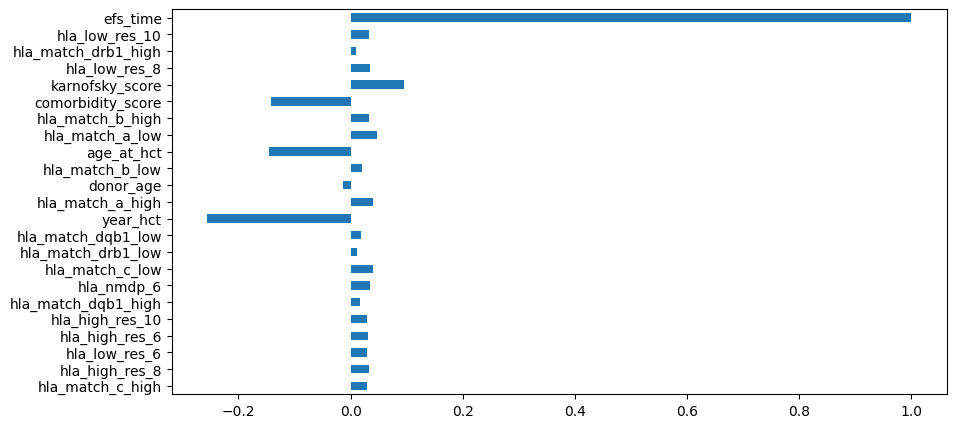

In [26]:
df1 = X_train[num_cols]

df1 = df1.join( labels_efs_time )

corr_matrix  = df1.corr()


# cols_ = df1.columns 

# plt.hist( cols_ , corr_matrix['efs_time']   )
# plt.show()
plt.figure( figsize = ( 10 , 5 ))

# plot corleation of all  Num  columns  with efs time 
df1.corrwith(df1['efs_time']).plot(kind='barh')

<Axes: >

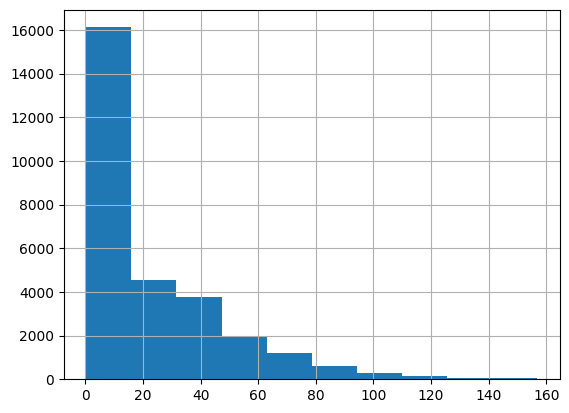

In [27]:
df1['efs_time'].hist()

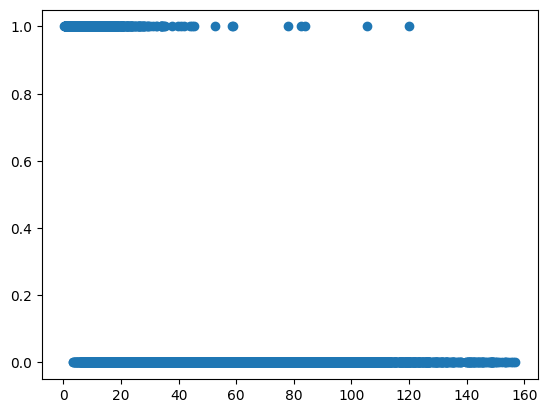

In [28]:
plt.scatter( labels_efs_time , labels_efs)
plt.show()

In [29]:
# There might be some linear decision bpundary b.w these 2 classes based on EFS TIME 

# so using SVM (with Gaussian / rbf kernel ) , i am transformaing hese vecotrs to high dim space 

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score

# extract  mean and std dev ( since i did not include this column initially )



time_data = (np.array(labels_efs_time).reshape(-1 , 1))

time_data_unscale  = time_data

mu = time_data.mean()
sigma = time_data.std()

# standarize it 

time_data_scale = ((time_data - mu) /sigma )


'''
CROSS VAL SCORE FOR DIFFERENT KERNELS FOR SVC BINARY CLASSIFICATION (MERCER THEORAM )

rbf => 0.976  (best)
poly=> 0.973
sigmoid => 0.975
'''

svc = SVC( kernel='rbf'  , probability =True ).fit(  time_data_scale , labels_efs  )


scores = cross_val_score( svc , time_data_scale , labels_efs  , cv = 3 )

print( "The cross validation score have Mean = {} a with a std. dev of = {}".format(scores.mean() ,scores.std()) )

The cross validation score have Mean = 0.9760416666666667 a with a std. dev of = 0.0010027450748745774


In [30]:
# Rebuild some ML models 

from sklearn.ensemble import RandomForestRegressor 

model_reg = RandomForestRegressor (
     n_estimators =   10 , criterion  = "squared_error" , max_depth = 6 ,
                               bootstrap = True ,warm_start = False 
)

model_reg.fit( X_train_pca , time_data )

# cross val uses a UTILITY  METRIC FUNCTION = - ( LOSS )
# larger the better 

scores = cross_val_score( model_reg  ,   X_train_pca , time_data ,scoring='neg_mean_squared_error', cv = 3 )

print( "The cross validation score have Mean = {} a with a std. dev of = {}".format(scores.mean() ,scores.std()) )

/tmp/ipykernel_23/2363141411.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_reg.fit( X_train_pca , time_data )
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

The cross validation score have Mean = -552.8366897695596 a with a std. dev of = 13.661064491386444


In [31]:
# Now SVC Data is Already Traine d( on fetaure s- efs time and labels = 0  or 1 )


In [32]:
# XGB regressor 

# Works on Predicting residulas = Y_true  - Y_pred_initial 
# and picks a feature , sorts the values , finds the mean and subtracts and then finds 
# Simialrity Score if less than threshaold Gamma (in a subset of split )
# Prunes the Branch 
# and adds it with LR alpha to Y_pred_initial + lr * tree_residuals 
# and does it iteratively  (thats why BOOSTING ( on eDT depends on errors made by former))

import xgboost as xgb 

xgb_model = xgb.XGBRegressor(
    n_estimators = 500 , 
    learning_rate = 0.01,
    max_depth = 6
)

xgb_model.fit (  X_train_pca , time_data )

scores = cross_val_score( xgb_model  ,   X_train_pca , time_data ,scoring='neg_mean_squared_error', cv = 3 )

print( "The cross validation score have Mean = {} a with a std. dev of = {}".format(scores.mean() ,scores.std()) )

The cross validation score have Mean = -542.3347340875927 a with a std. dev of = 12.5509857785046


In [33]:
# Now training my ANN model 


# # Neural Network 

from tensorflow import keras 

from keras.layers import Dense , Input , BatchNormalization , Dropout

model_nn = keras.models.Sequential()

model_nn.add( Input( shape = (X_train_pca.shape[1] ,) , batch_size = 256 ))

model_nn.add( Dense( 55  , activation = 'relu' ) ) 
model_nn.add( BatchNormalization())


model_nn.add( Dense( 100  , activation = 'relu' ) ) 
model_nn.add( BatchNormalization())

model_nn.add( Dense( 55 , activation = 'relu' ) ) 
model_nn.add( BatchNormalization())

# model_nn.add( Dense( 10  , activation = 'relu' ) ) 
# model_nn.add( BatchNormalization())

model_nn.add( Dense( 1  , activation = 'linear'))


model_nn.compile( loss = 'mean_squared_error' , optimizer = 'adam' , metrics = ['mean_squared_error'])

model_nn.fit( X_train_pca , time_data_scale , epochs = 30 )



Epoch 1/30


I0000 00:00:1734553117.229143      69 service.cc:145] XLA service 0x7d91fc004da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734553117.229198      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


101/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7479 - mean_squared_error: 1.7479

I0000 00:00:1734553118.623608      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1768 - mean_squared_error: 1.1768
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9191 - mean_squared_error: 0.9191
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9070 - mean_squared_error: 0.9070
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8704 - mean_squared_error: 0.8704
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8809 - mean_squared_error: 0.8809
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8726 - mean_squared_error: 0.8726
Epoch 7/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8701 - mean_squared_error: 0.8701
Epoch 8/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8588 - mean_squared_error: 0.8588
Epoch 9/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8601 - mean_squared_error: 0.8601
Epoch 10/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8659 - mean_squared_error: 0.8659
Epoch 11/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

In [34]:
# Now SVC is trained already 




In [35]:
# on Test Data 

# Order of feature sDuring Tetsing and Training should be same 

X_test = test_data[ train_data.columns ]


X_test_scale = scale_data.transform( X_test )
X_test_pca = PCA_.transform( X_test_scale )

# from NN 

efs_time_nn = model_nn.predict( X_test_pca )# predicts efs time (contnuous value )

# form XGB Boost 
efs_time_xgb = xgb_model.predict ( X_test_pca )

w_nn = 0.1
w_xgb =0.9 # to prevent overfitting some weight given to XXGB even when high MSE 

# combine both reusts with higher weightt to NN model 

# ! DONT FORGET TO RESHAPE INTO 1 COLUMN 
efs_time_xgb = efs_time_xgb.reshape(-1 , 1 )
efs_time_nn = efs_time_nn.reshape(-1 , 1 )

efs_time = ( w_nn * efs_time_nn) + (w_xgb * efs_time_xgb)

# standarize it 
efs_time = ((efs_time - mu) /sigma )

efs_label = svc.predict( efs_time )

y_labels = efs_label





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


In [36]:
submit = pd.DataFrame(
    {
        'ID' : test_id , 
        'prediction' : y_labels
    }
)

submit.head()

submit.to_csv('submission.csv' , index = False )